In [1]:
import xarray as xr
import numpy as np
from datetime import datetime
from calendar import monthrange
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import random
from datetime import datetime
import metpy
import xskillscore
import os

plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 13
})

In [2]:
root_dir = "/pscratch/sd/a/amahesh/hens/time_collection/nopert_33multicheckpoint_pert0p35_k1i3_500km_oppositepert_detfix_nodpr_timeevolve_hemisphererescale_target48_20minus20_newseed_repeat_qperturbfix_rankhist_qmin0/"

# Initialize an empty list to store file paths
file_paths = []

# List all subdirectories in the root directory
subdirs = [os.path.join(root_dir, d) for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
zarrs = []
# Check each subdirectory for the 'ensemble.zarr' file
for subdir in subdirs:
    file_path = os.path.join(subdir, "ensemble.zarr")
    ds = xr.open_zarr(file_path).isel(time=20, ensemble=np.arange(0,67,2))['t2m']
    zarrs.append(ds)
    


In [3]:
ds = xr.concat(zarrs, dim='initial_time')
ds

<xarray.DataArray 't2m' (initial_time: 52, ensemble: 34, lat: 721, lon: 1440)> Size: 7GB
dask.array<concatenate, shape=(52, 34, 721, 1440), dtype=float32, chunksize=(1, 1, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 3kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float32 6kB 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
    time     (initial_time) datetime64[ns] 416B 2018-07-15 ... 2018-08-26
Dimensions without coordinates: initial_time, ensemble
Attributes:
    long_name:  2m temperature
    units:      K

In [4]:
per_ens = []
np.random.seed(0)
weights = np.cos(np.deg2rad(ds['lat']))
for ensemble_size in range(4, 35, 5):
    sample_var = []
    for trial in range(200):
        sample = np.random.choice(34, size=ensemble_size, replace=True)
        sampled_ds = ds.sel(ensemble=sample)
        sample_var.append(np.sqrt(sampled_ds.var('ensemble', ddof=1).weighted(weights).mean(('lat', 'lon', 'initial_time')).load()))
    print('done')
    sample_var = xr.concat(sample_var, dim='trial')
    per_ens.append(sample_var)
        

done
done
done
done
done
done
done


In [5]:
per_ens = xr.concat(per_ens, dim='ensemble_size')
per_ens.to_netcdf("/pscratch/sd/a/amahesh/temp/per_ens.nc")

In [2]:
per_ens = xr.open_dataset("/pscratch/sd/a/amahesh/temp/per_ens.nc")['t2m']
per_ens

<xarray.DataArray 't2m' (ensemble_size: 7, trial: 200)> Size: 6kB
[1400 values with dtype=float32]
Dimensions without coordinates: ensemble_size, trial

In [3]:
list(range(4, 35, 5))

[4, 9, 14, 19, 24, 29, 34]

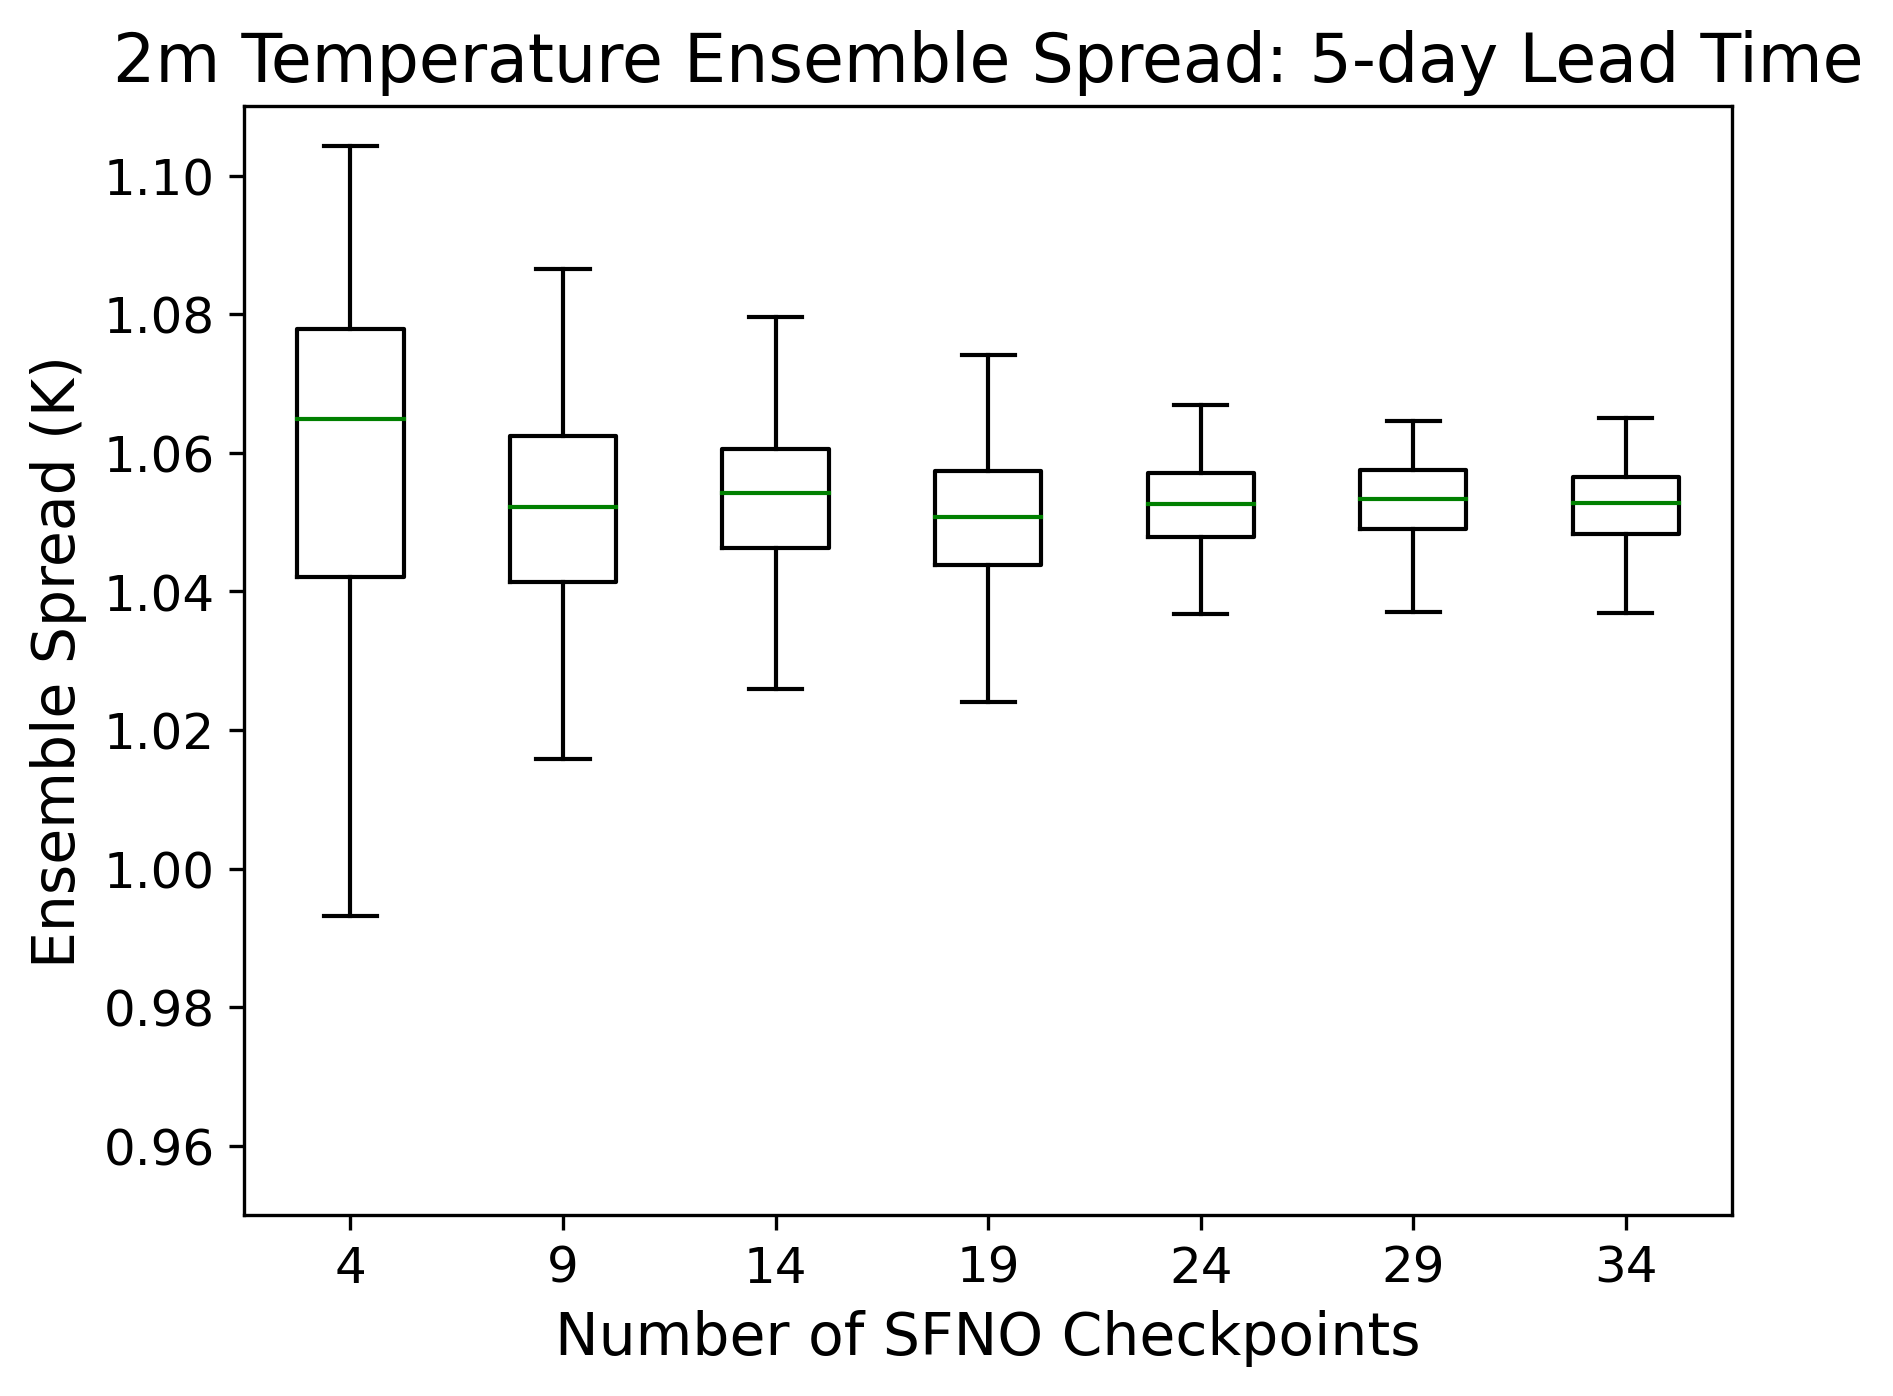

In [7]:
plt.figure(dpi=300)
box = plt.boxplot(per_ens.T, showfliers=False,
                 medianprops=dict(color='green'))
plt.ylim((0.95, 1.11))
plt.xlabel("Number of SFNO Checkpoints")
plt.xticks(range(1,8), labels=range(4, 35, 5))
plt.ylabel("Ensemble Spread (K)")
plt.title("2m Temperature Ensemble Spread: 5-day Lead Time")
#Make all elements of the box plot green


# Adjusting the axes labels and limits
plt.ylim((0.95, 1.11))
plt.savefig("why_29checkpoints.pdf")
# Display the plot
plt.show()

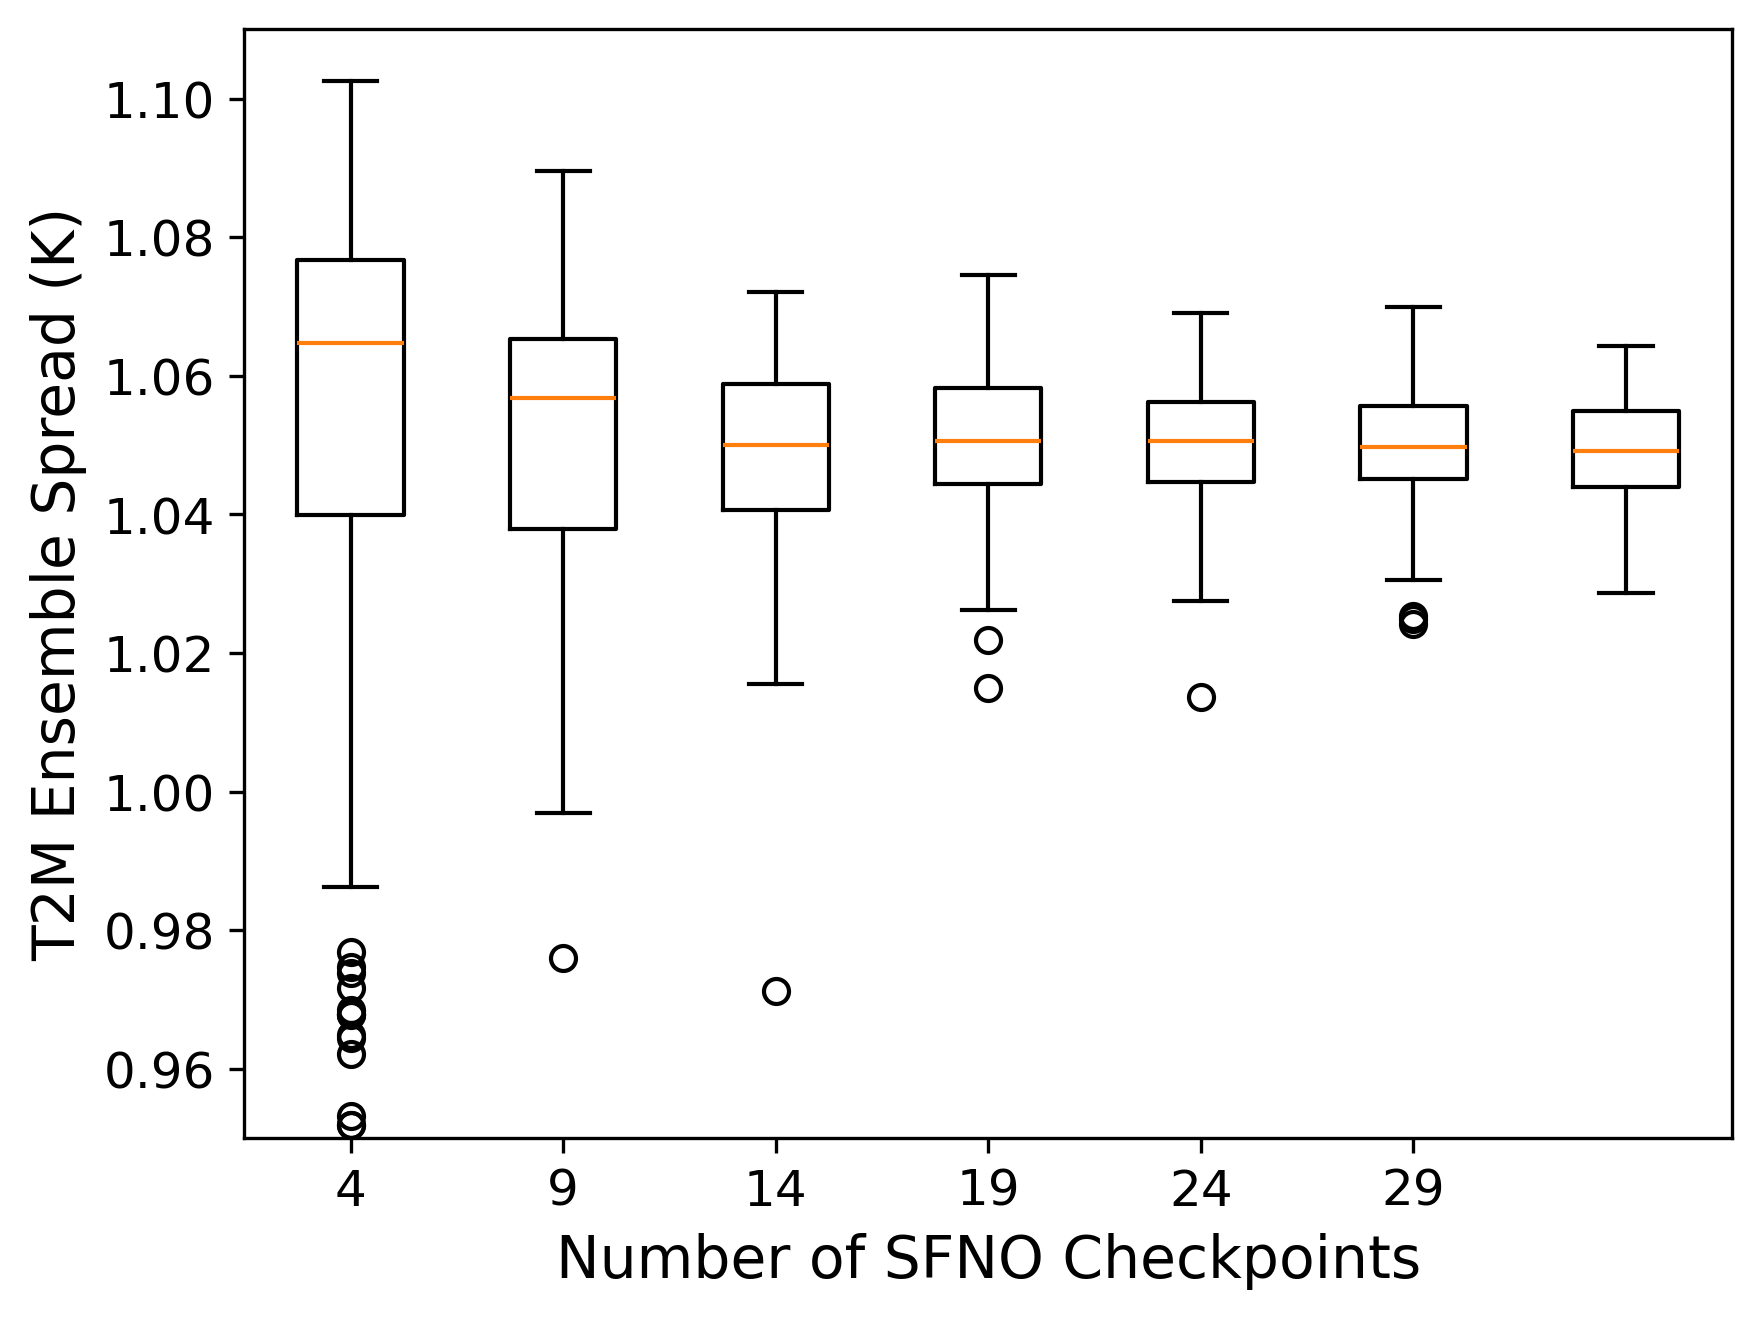

In [6]:
plt.figure(dpi=300)
box = plt.boxplot(per_ens.T)
plt.ylim((0.95, 1.11))
plt.xlabel("Number of SFNO Checkpoints")
plt.xticks(range(1,7), labels=range(4, 30, 5))
plt.ylabel("T2M Ensemble Spread (K)")
#Make all elements of the box plot green


# Adjusting the axes labels and limits
plt.ylim((0.95, 1.11))
plt.xlabel("Number of SFNO Checkpoints")
plt.xticks(range(1, 7), labels=range(4, 30, 5))
plt.ylabel("T2M Ensemble Spread (K)")
plt.savefig("why_29checkpoints.pdf")
# Display the plot
plt.show()

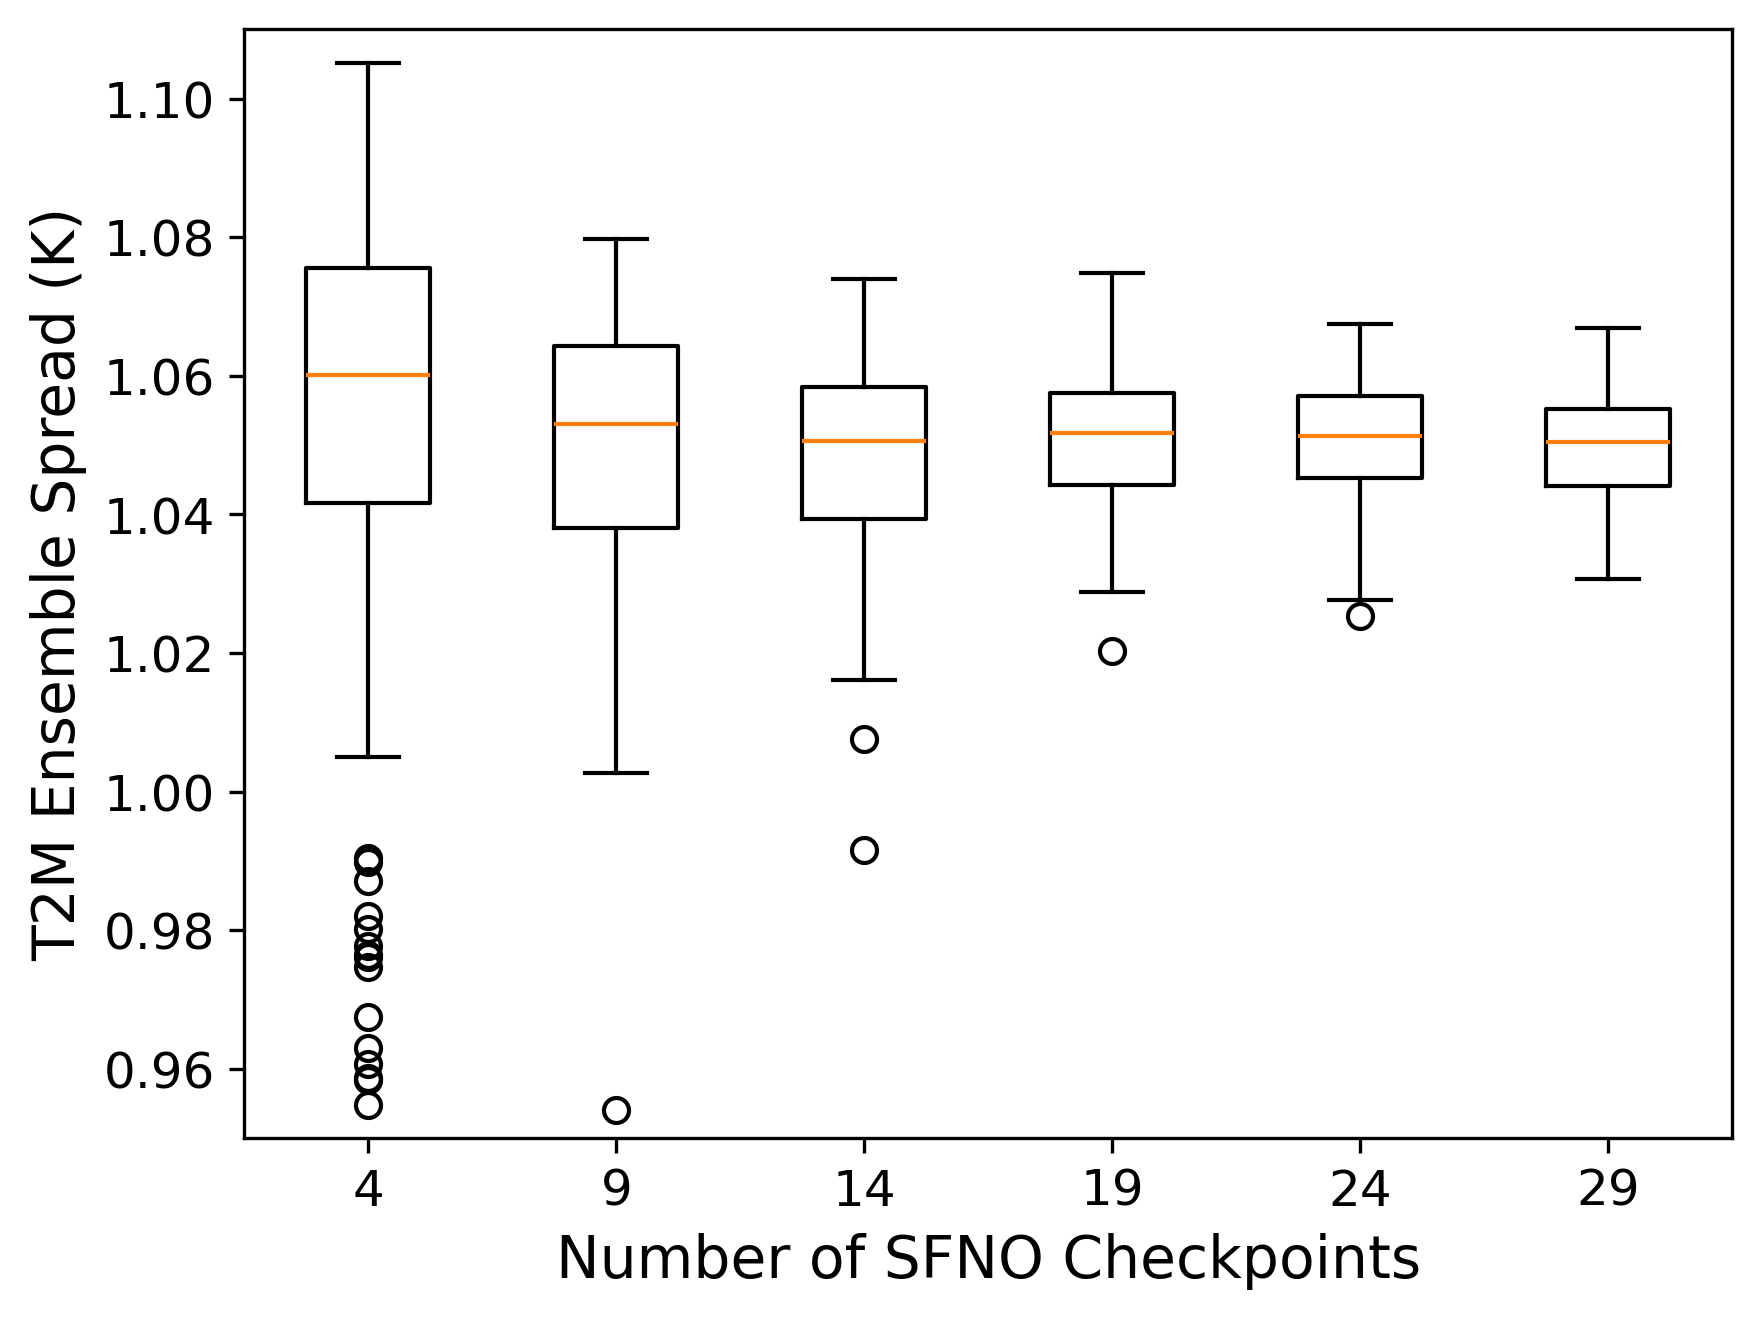

In [71]:
plt.figure(dpi=300)
box = plt.boxplot(per_ens.T)
plt.ylim((0.95, 1.11))
plt.xlabel("Number of SFNO Checkpoints")
plt.xticks(range(1,7), labels=range(4, 30, 5))
plt.ylabel("T2M Ensemble Spread (K)")
#Make all elements of the box plot green


# Adjusting the axes labels and limits
plt.ylim((0.95, 1.11))
plt.xlabel("Number of SFNO Checkpoints")
plt.xticks(range(1, 7), labels=range(4, 30, 5))
plt.ylabel("T2M Ensemble Spread (K)")
plt.savefig("why_29checkpoints.pdf")
# Display the plot
plt.show()

In [4]:
def open_var(var_name, dates, model):
    zarrs = []
    for date in dates:
        if model == 'ifs':
            factor=12
            PATH = f"/pscratch/sd/a/amahesh/ifs_extreme_scores/{date.year:02d}-{date.month:02d}-{date.day:02d}T00:00:00/"
        elif model == 'ifs-vs-analysis':
            factor=6
            PATH = f"/pscratch/sd/a/amahesh/ifs_extreme_scores_analysis/{date.year:02d}-{date.month:02d}-{date.day:02d}T00:00:00/"
        else:
            factor=6
            PATH=f"/pscratch/sd/a/amahesh/hens/time_collection/bred_29multicheckpoint_pert0p35_k1i3_500km_oppositepert_detfix_nodpr_timeevolve_hemisphererescale_target48_20minus20_newseed_repeat_qperturbfix_rankhist_qmin0_summer2023/{date.year}-{date.month:02d}-{date.day:02d}T00:00:00/"
        ds = xr.open_zarr(f"{PATH}/{var_name}",
                         decode_times=False)
        ds = ds.assign_coords({'time' : np.arange(0,ds['time'].shape[0])*factor})
        zarrs.append(ds)
    return xr.concat(zarrs, dim='initial_condition')


In [5]:
from datetime import datetime

# List of date strings extracted from the filenames
date_strings = [
    "20230601", "20230602", "20230604", "20230605", "20230606", "20230607", "20230608",
    "20230609", "20230610", "20230611", "20230612", "20230613", "20230623", "20230624",
    "20230727", "20230728", "20230729", "20230730", "20230731",
    "20230801", "20230802", "20230803", "20230804", "20230805", "20230806", "20230807", "20230826"
]

# Convert strings to datetime objects
dates = [datetime.strptime(date, "%Y%m%d") for date in date_strings]

In [6]:
thresholded_verif = open_var('extreme_stats/percentile_0.99/thresholded_verification.zarr', dates, 'sfno')
thresholded_pred = open_var('extreme_stats/percentile_0.99/thresholded_ensemble_mean.zarr', dates, 'sfno')

In [7]:
upper, lower = 90,-90

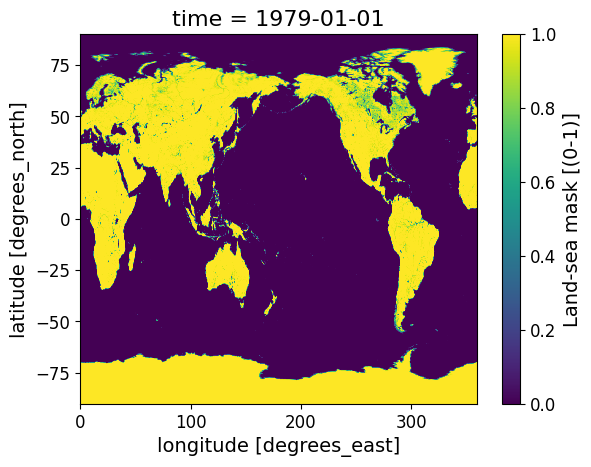

In [8]:
lsm = xr.open_dataset("/global/cfs/cdirs/m3522/cmip6/ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc")
lsm = lsm['LSM'].squeeze().rename({'latitude' : 'lat', 'longitude' : 'lon'})
lsm.plot()

In [9]:
thresholded_verif = xr.where(lsm > 0, thresholded_verif, 0)
thresholded_pred = xr.where(lsm > 0, thresholded_pred, 0)

In [31]:
small_reliability = xskillscore.reliability(thresholded_verif.sel(lat=slice(upper, lower)), thresholded_pred.sel(lat=slice(upper, lower)), dim=('initial_condition', 'lat', 'lon'),
                                          probability_bin_edges=np.arange(0,1.01,0.1))

In [8]:
hens = xr.open_mfdataset("//pscratch/sd/a/amahesh/hens_h5/mpi_stats/stats_*.nc",
                        concat_dim='initial_condition', combine='nested').rename({'lead_time' : 'time'})
# hens = xr.open_dataset("//pscratch/sd/a/amahesh/hens_h5/mpi_stats/stats_20230601.nc").rename({'lead_time' : 'time'})
hens['time'] =hens['time'] *6


In [12]:
hens = xr.where(lsm > 0, hens, 0)

In [34]:
hens_reliability = xskillscore.reliability(thresholded_verif.sel(lat=slice(upper, lower)), hens['t2m_count_above_threshold'].sel(lat=slice(upper, lower))/7424, dim=('initial_condition', 'lat', 'lon'),
                                          probability_bin_edges=np.arange(0,1.01,0.1))

/global/common/software/m4416/fcn_mip-env/lib/python3.10/site-packages/xarray/core/variable.py:1446: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._stack_once(dims, new_dim)


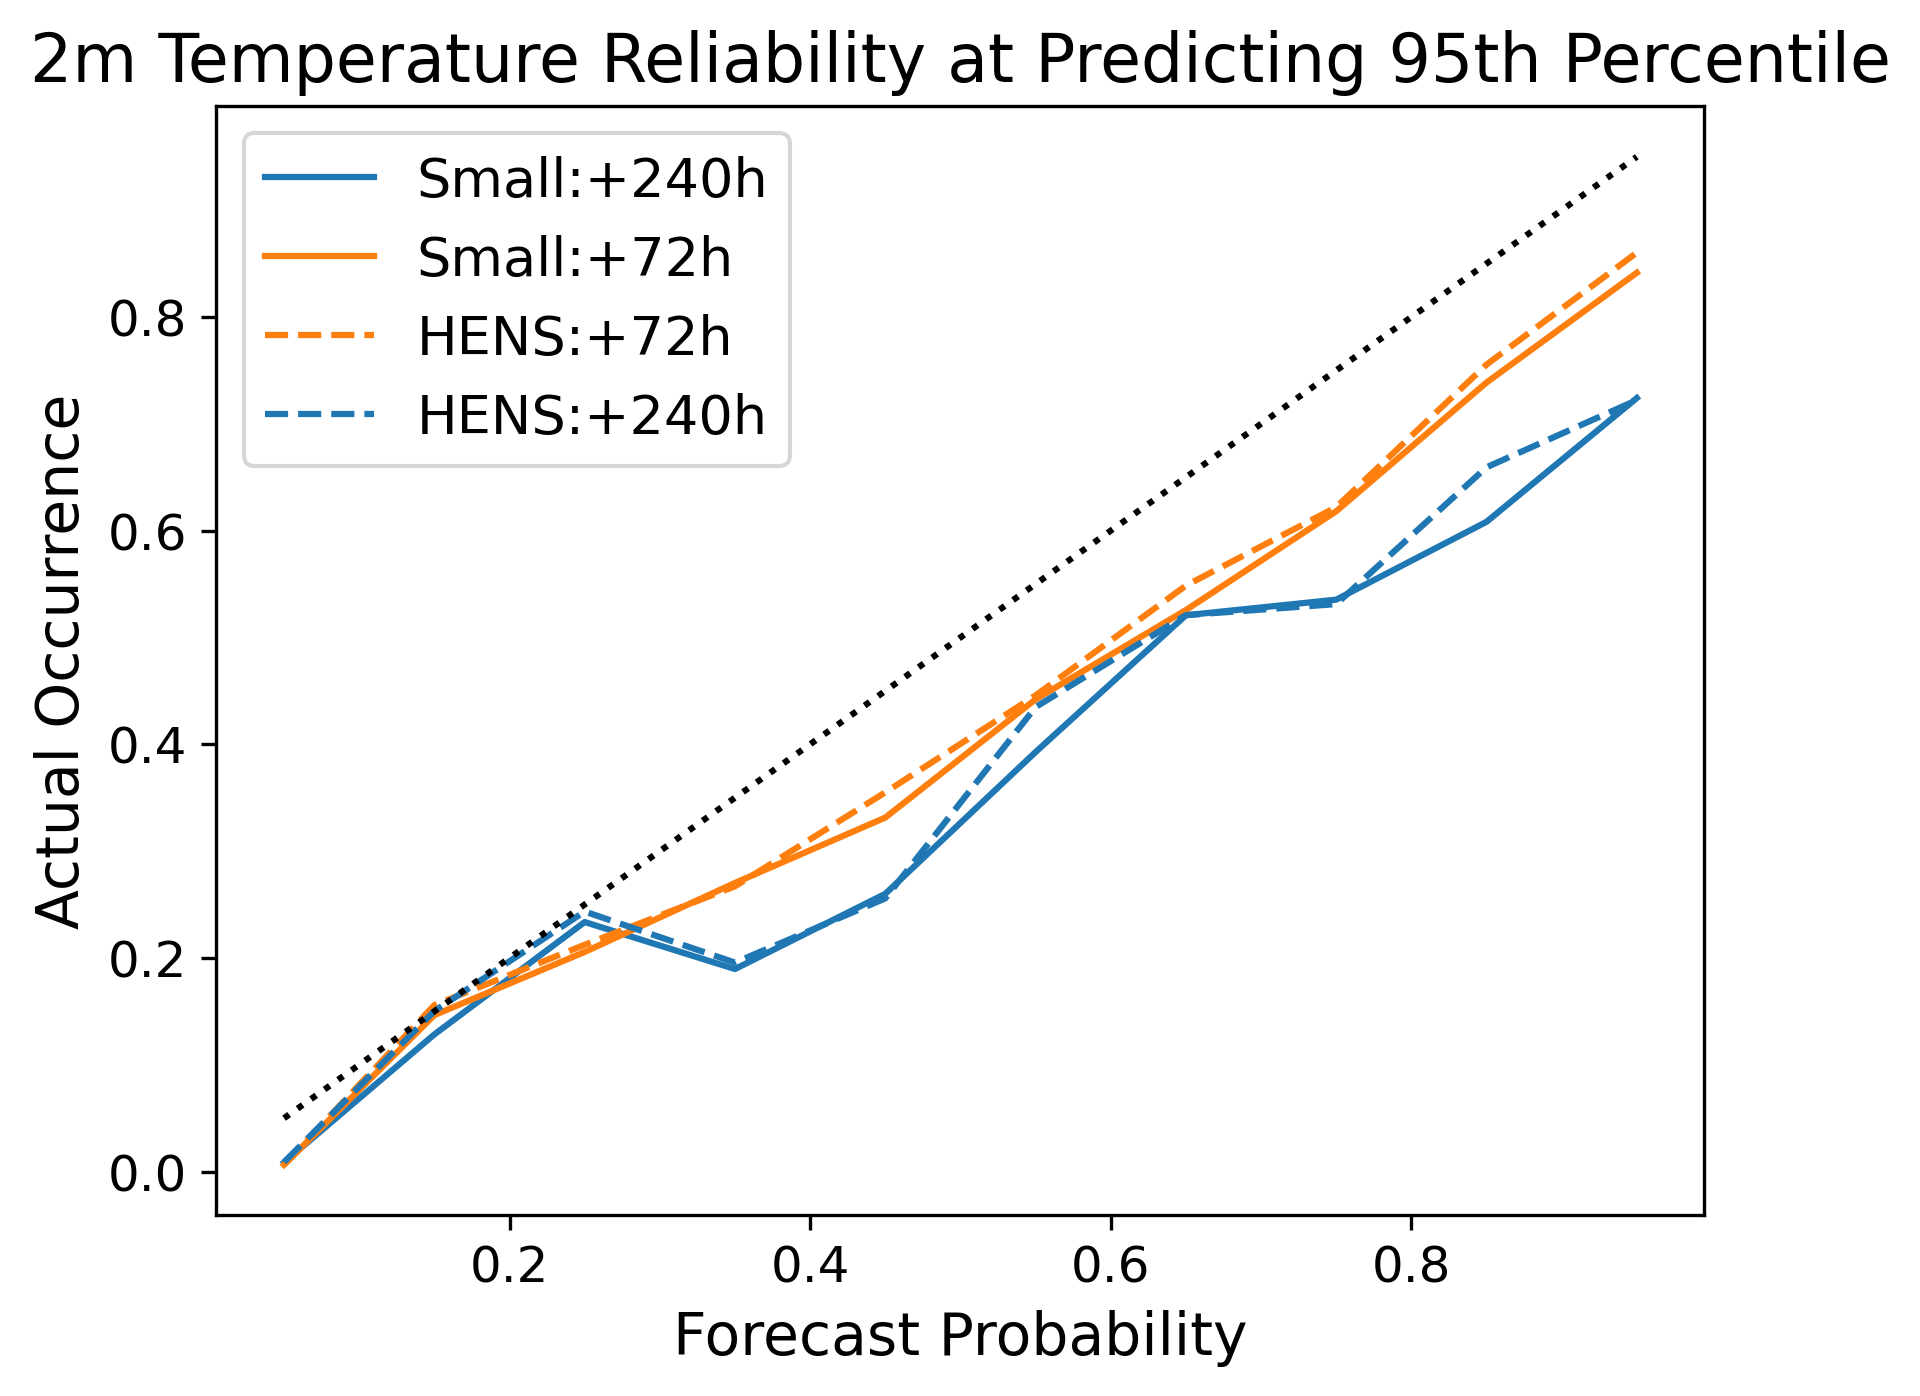

In [35]:
plt.figure(dpi=300)
small_reliability['t2m'].isel(time=40).plot(label='Small:+240h')
small_reliability['t2m'].isel(time=24).plot(label='Small:+72h')
hens_reliability['t2m'].isel(time=24).plot(label='HENS:+72h', color='C1', linestyle='--')
hens_reliability['t2m'].isel(time=40).plot(label='HENS:+240h', color='C0', linestyle='--')

hens_reliability['forecast_probability'].plot(linestyle='dotted',
                                        color='black')
plt.legend()
plt.title("2m Temperature Reliability at Predicting 95th Percentile")
plt.ylabel('Actual Occurrence')
plt.xlabel("Forecast Probability")
plt.show()

In [13]:
chunked_verif = thresholded_verif.sel(lat=slice(upper, lower))['t2m'].load().chunk({'time' : 1})
chunked_hens = (hens['t2m_count_above_threshold'].sel(lat=slice(upper, lower)).load()/7424).chunk({'time' : 1})

In [14]:
upper, lower = 55, 15

In [23]:
hens_roc = xskillscore.roc(chunked_verif.sel(lat=slice(upper, lower)).chunk({'lat' : 100}), chunked_hens.sel(lat=slice(upper, lower)).chunk({'lat' : 100}), dim=('initial_condition', 'lat', 'lon'),
                                          bin_edges = np.arange(0,1.01,0.005),
                          return_results='all_as_metric_dim')

/global/common/software/m4416/fcn_mip-env/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


In [24]:
small_roc = xskillscore.roc(thresholded_verif.sel(lat=slice(upper, lower))['t2m'].chunk({'lat' : 100, 'time' : 1}), thresholded_pred.sel(lat=slice(upper, lower))['t2m'].chunk({'lat' : 100,
'time' : 1}), dim=('initial_condition', 'lat', 'lon'),
                           bin_edges = np.arange(0,1.01,0.01),
                          return_results='all_as_metric_dim')

/global/common/software/m4416/fcn_mip-env/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


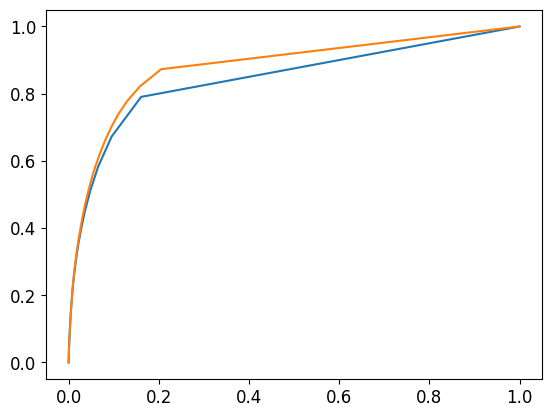

In [32]:
plt.plot(small_roc.sel(metric='false positive rate').isel(time=40),
        small_roc.sel(metric='true positive rate').isel(time=40))
plt.plot(hens_roc.sel(metric='false positive rate').isel(time=40),
        hens_roc.sel(metric='true positive rate').isel(time=40))

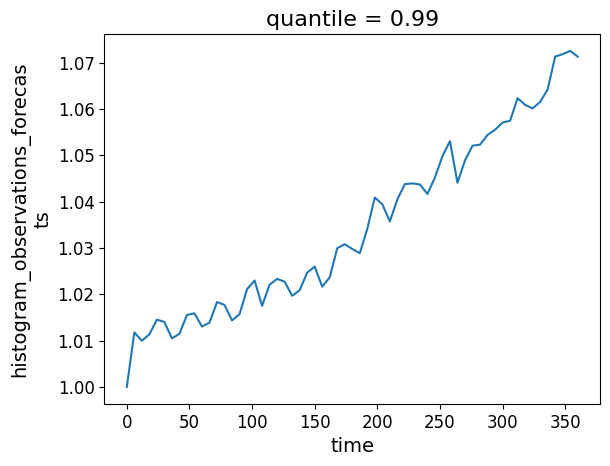

In [22]:
(hens_roc/small_roc).plot()

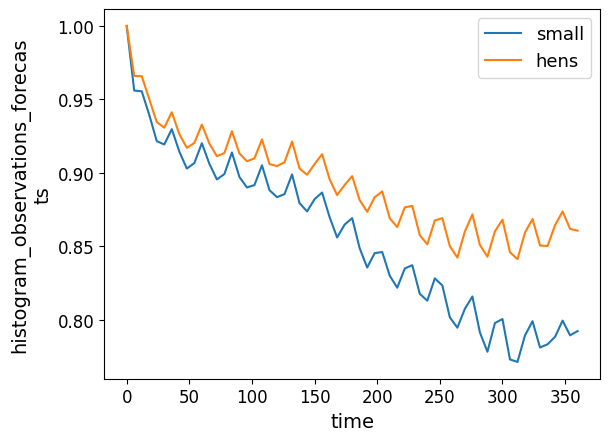

In [41]:
small_roc.plot(label='small')
hens_roc.plot(label='hens')
plt.legend()

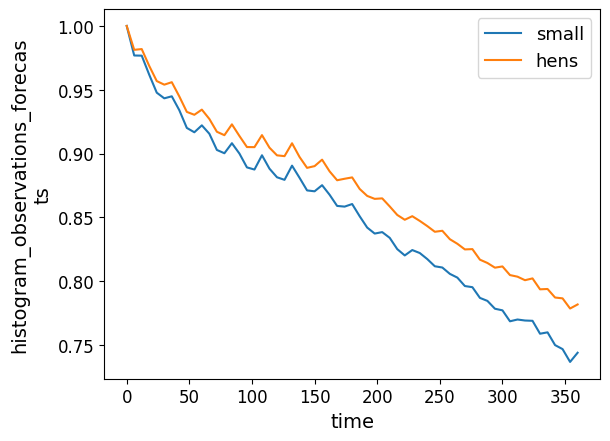

In [18]:
small_roc.plot(label='small')
hens_roc.plot(label='hens')
plt.legend()

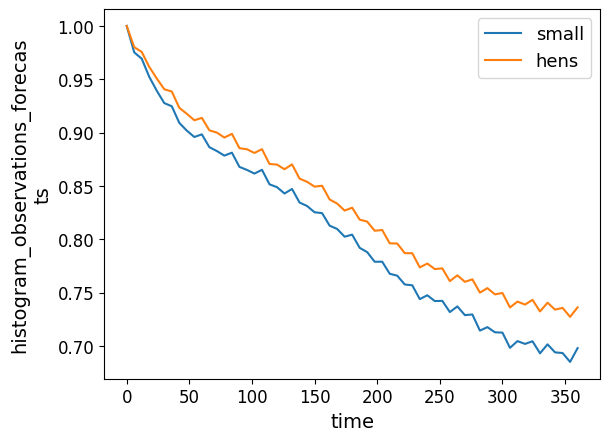

In [11]:
small_roc.plot(label='small')
hens_roc.plot(label='hens')
plt.legend()

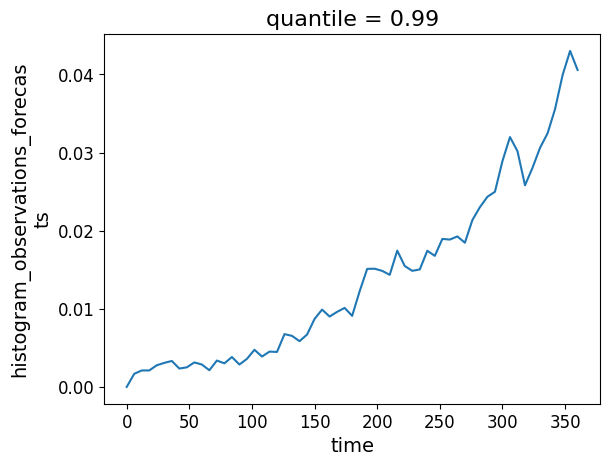

In [25]:
((hens_roc - small_roc)/small_roc).plot()

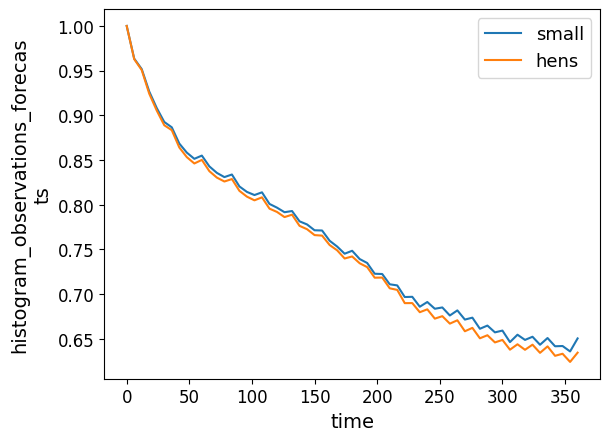

In [15]:
small_roc.plot(label='small')
hens_roc.plot(label='hens')
plt.legend()

In [4]:
small = xr.open_zarr("/pscratch/sd/a/amahesh/hens/time_collection/bred_29multicheckpoint_pert0p35_k1i3_500km_oppositepert_detfix_nodpr_timeevolve_hemisphererescale_target48_20minus20_newseed_repeat_qperturbfix_rankhist_qmin0_summer2023/2023-06-01T00:00:00/extreme_stats/percentile_0.99/thresholded_ensemble_mean.zarr")
small

<xarray.Dataset> Size: 507MB
Dimensions:   (lat: 721, lon: 1440, time: 61)
Coordinates:
  * lat       (lat) float32 3kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon       (lon) float32 6kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
    quantile  float64 8B ...
  * time      (time) datetime64[ns] 488B 2023-06-01 ... 2023-06-16
Data variables:
    t2m       (time, lat, lon) float64 507MB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>

In [5]:
true = xr.open_zarr("/pscratch/sd/a/amahesh/hens/time_collection/bred_29multicheckpoint_pert0p35_k1i3_500km_oppositepert_detfix_nodpr_timeevolve_hemisphererescale_target48_20minus20_newseed_repeat_qperturbfix_rankhist_qmin0_summer2023/2023-06-01T00:00:00/extreme_stats/percentile_0.99/thresholded_verification.zarr")

In [ ]:
(small['t2m'].isel(time=40) * 58).plot(vmin=2)
plt.show()
(hens['t2m_count_above_threshold'].isel(initial_condition=0, time=40)).plot(vmax=0.8)
plt.show()

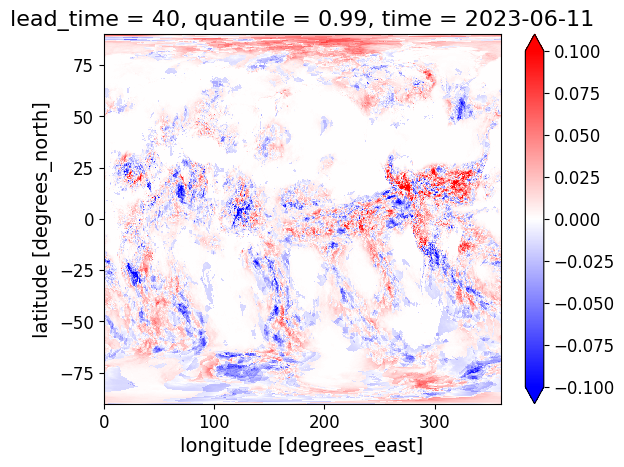

In [4]:
(hens['t2m_count_above_threshold'].isel(lead_time=40)/7424-small['t2m'].isel(time=40)).plot(vmin=-0.1, vmax=0.1,
                                                                                           cmap='bwr')

In [73]:
import xskillscore

In [74]:
hens_pred = xr.DataArray(
    hens['t2m_count_above_threshold'] / 7424,
    coords={'time': small['time'], 'lat': small['lat'], 'lon': small['lon']},
    dims=['time', 'lat', 'lon'],
    name='t2m'
)


In [56]:
hens_reliability = xskillscore.reliability(true, hens_pred.to_dataset(), dim=('lat', 'lon'),
                                          probability_bin_edges=np.arange(0,1.01,0.05))

In [57]:
small_reliability = xskillscore.reliability(true, small, dim=('lat', 'lon'),
                                          probability_bin_edges=np.arange(0,1.01,0.05))

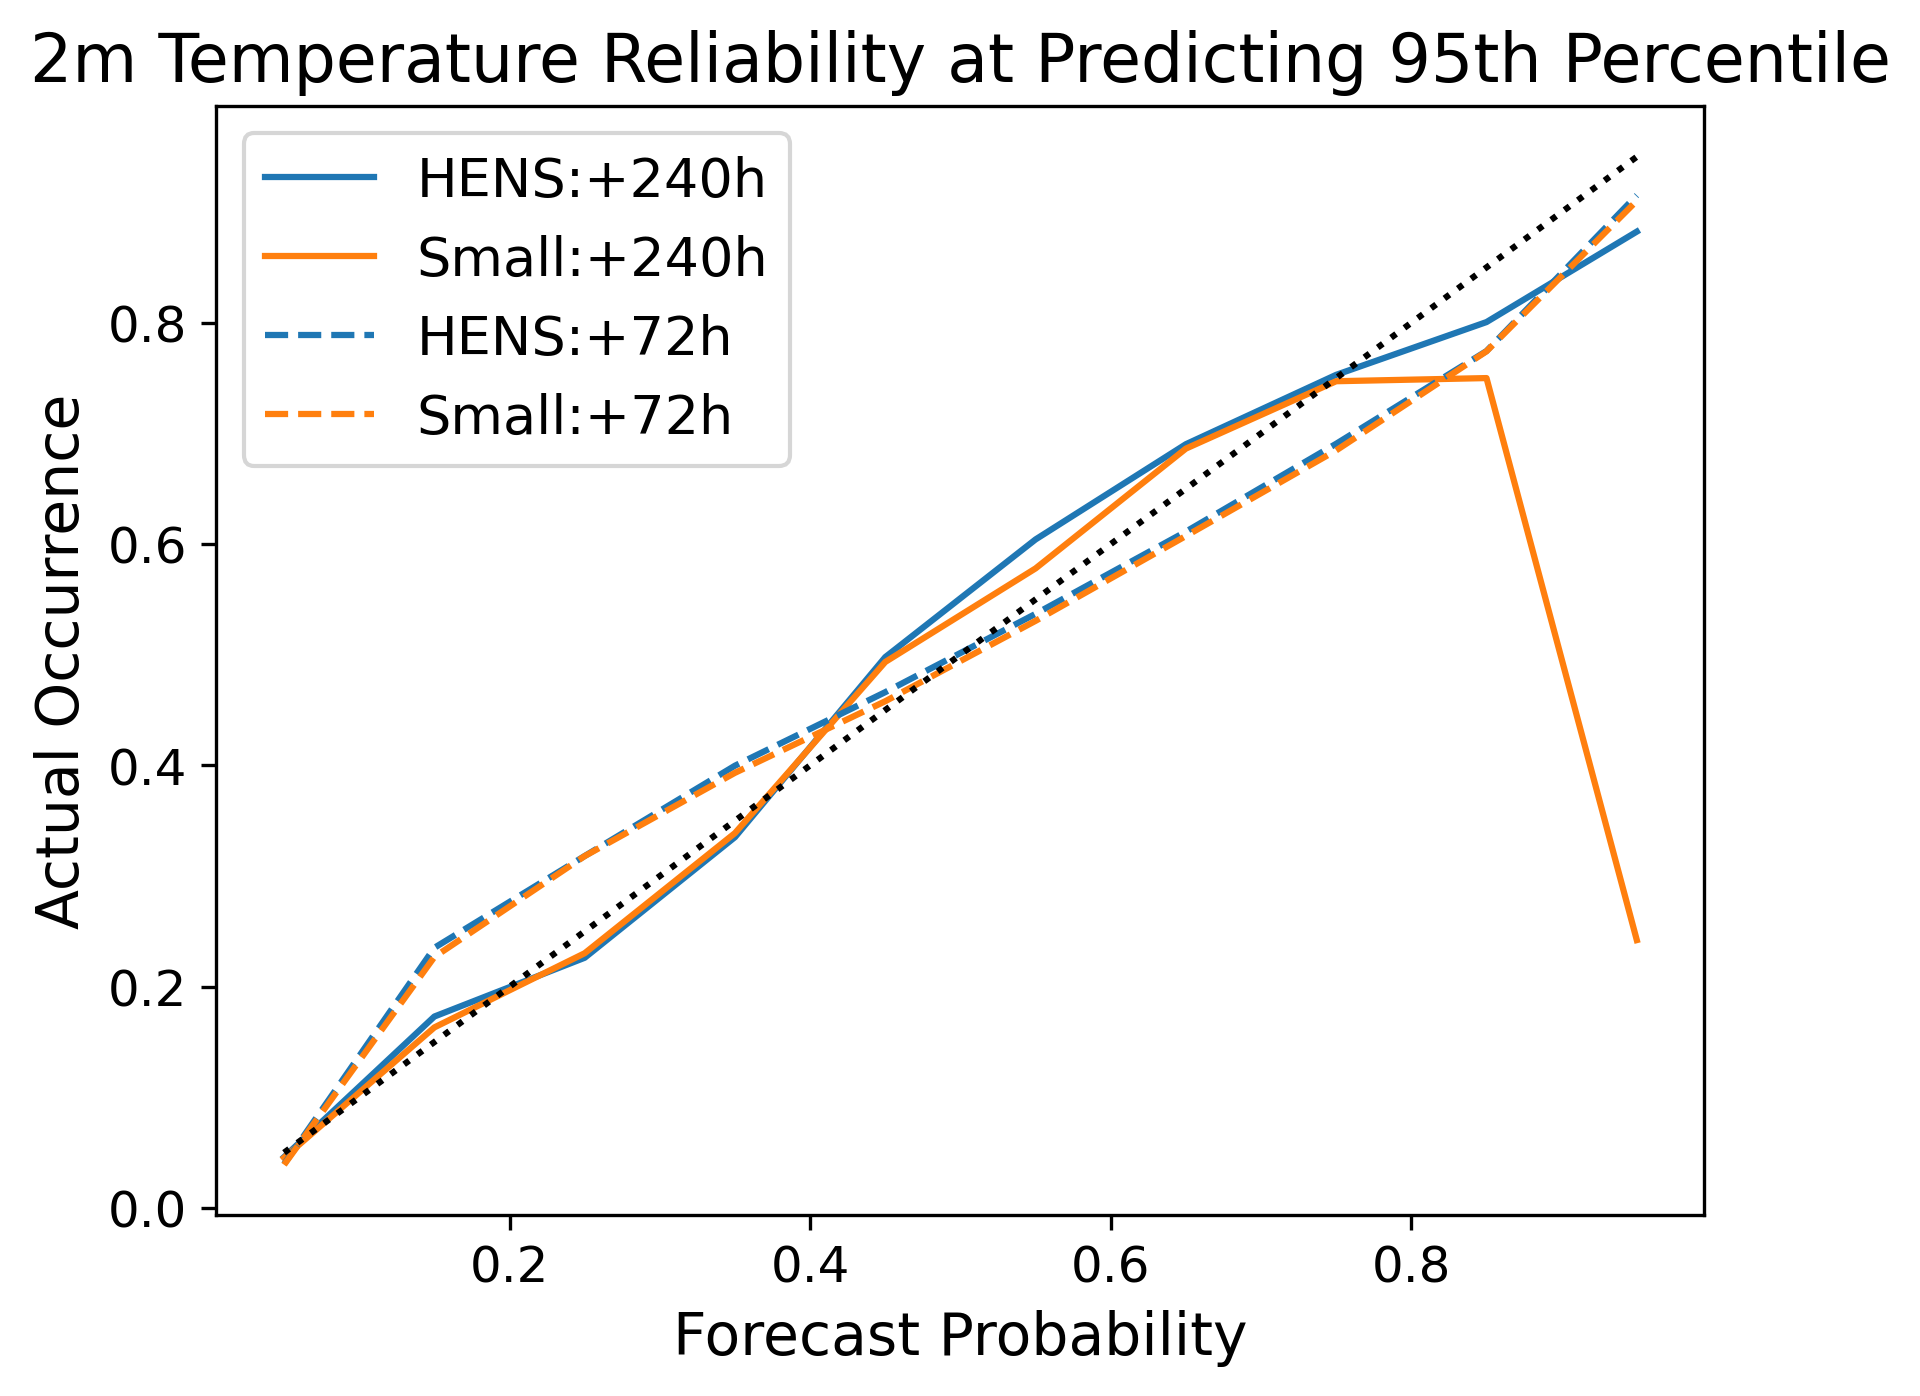

In [128]:
plt.figure(dpi=300)
hens_reliability['t2m'].isel(time=40).plot(label='HENS:+240h')
small_reliability['t2m'].isel(time=40).plot(label='Small:+240h')
hens_reliability['t2m'].isel(time=12).plot(label='HENS:+72h', color='C0', linestyle='--')
small_reliability['t2m'].isel(time=12).plot(label='Small:+72h', color='C1', linestyle='--')


hens_reliability['forecast_probability'].plot(linestyle='dotted',
                                        color='black')
plt.legend()
plt.title("2m Temperature Reliability at Predicting 95th Percentile")
plt.ylabel('Actual Occurrence')
plt.xlabel("Forecast Probability")
plt.show()

In [51]:
hens_reliability

<xarray.Dataset> Size: 5kB
Dimensions:               (time: 61, forecast_probability: 5)
Coordinates:
    grid_type             <U11 44B ...
    quantile              float64 8B ...
  * time                  (time) datetime64[ns] 488B 2023-06-01 ... 2023-06-16
  * forecast_probability  (forecast_probability) float64 40B 0.1 0.3 0.5 0.7 0.9
    t2m_samples           (time, forecast_probability) int64 2kB dask.array<chunksize=(61, 5), meta=np.ndarray>
Data variables:
    t2m                   (time, forecast_probability) float64 2kB dask.array<chunksize=(1, 5), meta=np.ndarray>

In [16]:
hens_reliability[0]

<xarray.Dataset> Size: 172B
Dimensions:               (forecast_probability: 5)
Coordinates:
    grid_type             <U11 44B ...
    quantile              float64 8B ...
  * forecast_probability  (forecast_probability) float64 40B 0.1 0.3 0.5 0.7 0.9
    t2m_samples           (forecast_probability) int64 40B dask.array<chunksize=(5,), meta=np.ndarray>
Data variables:
    t2m                   (forecast_probability) float64 40B dask.array<chunksize=(5,), meta=np.ndarray>

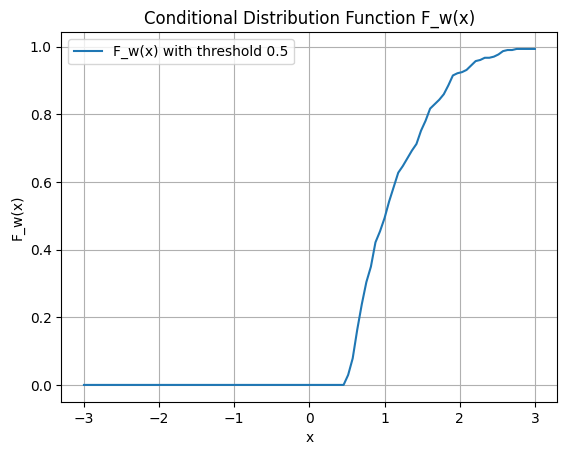

In [3]:
import numpy as np

# Step 1: Generate a sample dataset
np.random.seed(42)
data = np.random.randn(1000)  # Generating 1000 random numbers from a normal distribution

# Step 2: Define the threshold t
threshold = 0.5

# Step 3: Define the weighting function w(X)
def weighting_function(x, t):
    return np.where(x > t, 1, 0)

# Step 4: Calculate the numerator and the denominator
def calculate_Fw(x, data, t):
    w = weighting_function(data, t)
    
    indicator_function = np.where(data <= x, 1, 0)
    
    numerator = np.mean(indicator_function * w)
    denominator = np.mean(w)
    
    if denominator == 0:
        return 0  # To handle cases where there are no values greater than the threshold
    
    return numerator /denominator

# Step 5: Compute F_w(x) for a given x
x_values = np.linspace(-3, 3, 100)  # Range of x values to compute F_w(x)
Fw_values = [calculate_Fw(x, data, threshold) for x in x_values]

import matplotlib.pyplot as plt

# Plotting the result
plt.plot(x_values, Fw_values, label=f'F_w(x) with threshold {threshold}')
plt.xlabel('x')
plt.ylabel('F_w(x)')
plt.title('Conditional Distribution Function F_w(x)')
plt.legend()
plt.grid(True)
plt.show()
